# Text Classification with Pre-trained Embeddings & Deep Convolutional Neural Network (CNN)

## 1. Movie Review Dataset

- The Movie Review Data is a collection of movie reviews retrieved from imdb.com in the early 2000s by Bo Pang and Lillian Lee. The reviews were collected and made available as part of their research on natural language processing. The reviews were originally released in 2002, but an updated and cleaned up version were released in 2004, referred to as “v2.0”.

- The dataset is comprised of 1,000 positive and 1,000 negative movie reviews drawn from an archive of rec.arts.movies.reviews newsgroup hosted at imdb.com. The authors refer to this dataset as the “polarity dataset.”

- The data has been cleaned up somewhat, for example:
    - The dataset is comprised of only English reviews.
    - All text has been converted to lowercase.
    - There is white space around punctuation like periods, commas and brackets.
    - Text has been split into one sentence per line.

- The data has been used for a few related natural language processing tasks. For classification, the performance of machine learning models (such as Support Vector Machines) on the data is in the range of high 70% to low 80% (e.g. 78%-82%).

- More sophisticated data preparation may see results as high as 86% with 10-fold cross validation. This gives us a ballpark of low-to-mid 80s if we were looking to use this dataset in experiments of modern methods.

- You can download the dataset from here :- [Movie Review Polarity Dataset](http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz) (review_polarity.tar.gz, 3MB)

- After unzipping the file, you will have a directory called “txt_sentoken” with two sub-directories containing the text “neg” and “pos” for negative and positive reviews respectively. Reviews are stored one per file with a naming convention cv000 to cv999 for each neg and pos.

In [5]:
# import necessary libraries
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from os import listdir
from numpy import array, asarray, zeros
import tensorflow as tf
from itertools import islice
import matplotlib.pyplot as plt

# print tensorflow version
print(f'TensorFlow Version is {tf.__version__}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
TensorFlow Version is 2.2.0


[tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file)

In [0]:
# dataset URL
#URL = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz'
# get dataset and extract
#path = tf.keras.utils.get_file('review_polarity', origin=URL, extract=True, cache_dir='/content/')
#print(f'Path : {path}')

In [2]:
# download the dataset
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2020-06-15 00:54:33--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  1.09MB/s    in 2.7s    

2020-06-15 00:54:36 (1.09 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



In [0]:
# extract the data
!tar -xf review_polarity.tar.gz

## 2. Data Preparation

In this section, we will look at 3 things:

* A. Separation of data into training and testing set.

* B. Loading and cleaning the data to remove punctuation and numbers.

* C. Defining a vocabulary of preferred words.

### A. Split into Train and Test Sets
- We are pretending that we are developing a system that can predict the sentiment of a textual movie review as either positive or negative.

- This means that after the model is developed, we will need to make predictions on new textual reviews. This will require all of the same data preparation to be performed on those new reviews as it is performed on the training data for the model.

- We will ensure that this constraint is built into the evaluation of our model by splitting the training and test datasets prior to any data preparation. This means that any knowledge in the data in the test set that could help us better prepare the data (e.g. the words used) are unavailable in the preparation of data used for training the model.

- That being said, we will use the last 100 positive reviews and the last 100 negative reviews as a test set (100 reviews) and the remaining 1,800 reviews as the training dataset. This is a 90% train, 10% split of the data. The split can be imposed easily by using the filenames of the reviews where reviews named 000 to 899 are for training data and reviews named 900 onwards are for test.

### B. Loading and Cleaning Reviews

- The text data is already pretty clean not much preparation is required. If you are new to cleaning text data, see this post :- [How to Clean Text for Machine Learning with Python](https://machinelearningmastery.com/clean-text-machine-learning-python/)

- We will prepare the data using the following way:

    - Split tokens on white space.
    - Remove all punctuation from words.
    - Remove all words that are not purely comprised of alphabetical characters.
    - Remove all words that are known stop words.
    - Remove all words that have a length <= 1 character.

- We can put all of these steps into a function called clean_text( ) that takes as an argument the raw text loaded from a file and returns a list of cleaned tokens. We can also define a function load_text( ) that loads a document from file ready for use with the clean_text( ) function.

In [0]:
# load text into memory
def load_text(filename):
    # open the file as read only
    file = open(filename, mode='r')
    # read all the text
    text = file.read()
    # close the file
    file.close()
    return text

In [0]:
# clean the text and return it as tokens
def clean_text(text):
    # split the text on white space
    tokens = text.split()
    # remove punctuations from each token
    table = str.maketrans('', '', punctuation)
    tokens = [t.translate(table) for t in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

### C. Define a Vocabulary
- It is important to define a vocabulary of known words when using a bag-of-words or embedding model. The more words, the larger the representation of documents, therefore it is important to constrain the words to only those believed to be predictive. This is difficult to know beforehand and often it is important to test different hypothesis about how to construct a useful vocabulary.

- We have already seen how we can remove punctuation and numbers from the vocabulary in the previous section. We can repeat this for all documents and build a set of all known words. We can develop a vocabulary as a Counter, which is a dictionary mapping of words and their counts that allow us to easily update and query.

- Each document can be added to the counter and we can step over all of the reviews in the negative directory and then the positive directory through a function called process_files( ).

In [0]:
# load all the files in a directory
def process_files(directory, vocab, is_train):
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create full path of the file to open
        path = directory + '/' + filename
        # load the text files
        text = load_text(path)
        # tokenize the text
        tokens = clean_text(text)
        # update vocab counts
        vocab.update(tokens)

In [6]:
# define vocab
vocab = Counter()

# add all files to vocab
process_files('/content/txt_sentoken/pos', vocab, True)
process_files('/content/txt_sentoken/neg', vocab, True)

# print the size of vocabulary
print(f'Words in Vocabulary :- {len(vocab)}')

# print top 10 most common words in the vocabulary
print(f'Top 10 most common words in the Vocabulary :- {vocab.most_common(10)}')

Words in Vocabulary :- 44276
Top 10 most common words in the Vocabulary :- [('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844)]


-  The vocabulary can be saved to a new file called *vocab.txt* that we can later load and use to filter movie reviews prior to encoding them for modeling. We define a new function called save_list( ) that saves the vocabulary to file, with one word per file.

In [0]:
tokens = [k for k, _ in vocab.items()]

# save vocab to a file
def save_list(tokens, filename):
    # convert tokens to a single blob of text
    data = '\n'.join(tokens)
    # open file
    file = open(filename, mode='w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

In [9]:
# check out first 10 tokens
tokens[:10]

['grandfather',
 'italian',
 'horror',
 'late',
 'mario',
 'bava',
 'credits',
 'nearly',
 'films',
 'tv']

In [10]:
type(vocab)

collections.Counter

In [11]:
# check out first 10 Vocabulary items
list(islice(vocab.items(), 10))

[('grandfather', 23),
 ('italian', 50),
 ('horror', 384),
 ('late', 204),
 ('mario', 15),
 ('bava', 6),
 ('credits', 171),
 ('nearly', 278),
 ('films', 1873),
 ('tv', 280)]

## 3. Train Embedding 

- In this section, we will learn a word embedding while training a neural network on the classification problem.

- A word embedding is a way of representing text where each word in the vocabulary is represented by a real valued vector in a high-dimensional space. The vectors are learned in such a way that words that have similar meanings will have similar representation in the vector space (close in the vector space). This is a more expressive representation for text than classical methods like bag-of-words where relationships between words or tokens are ignored or forced in bigram and trigram approaches.

- The real valued vector representation for words can be learned while training the neural network. We can do this in the Keras deep learning library using the [Embedding Layer](https://keras.io/layers/embeddings/).

- If you are new to word embeddings, see the post :- [What Are Word Embeddings for Text?](https://machinelearningmastery.com/what-are-word-embeddings/)

- If you are new to word embedding layers in Keras, see the post :- [How to Use Word Embedding Layers for Deep Learning with Keras.](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

- The first step is to load the vocabulary. We will use it to filter out words from movie reviews that we are not interested in. If you have worked through the previous section, you should have a local file called 'vocab.txt' with one word per line. We can load that file and build a vocabulary as a set for checking the validity of tokens.

In [0]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_text(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [13]:
# check out first 10 Vocabulary words
list(vocab)[:10]

['designers',
 'windswept',
 'crew',
 'thompsonbased',
 'meschach',
 'barby',
 'shake',
 'disgusted',
 'afred',
 'predators']

- Next, we need to load all of the training data movie reviews. For that we can adapt the process_docs( ) from the previous section to load the documents, clean them and return them as a list of strings, with one document per string. We want each document to be a string for easy encoding as a sequence of integers later.

- Cleaning the document involves splitting each review based on white space, removing punctuation and then filtering out all tokens not in the vocabulary. The updated clean_doc( ) function is listed below.

- The updated process_docs( ) can then call the clean_doc( ) for each document on the 'pos' and 'neg' directories that are in our training dataset.

In [0]:
# tokenize the text
def clean_doc(doc, vocab):
    # split the text on white space
    tokens = doc.split()
    # remove punctuations from each token
    table = str.maketrans('', '', punctuation)
    tokens = [t.translate(table) for t in tokens]
    # filter out tokens not in vocab
    tokens = [word for word in tokens if word in vocab]
    tokens = ' '.join(tokens)
    return tokens

In [0]:
# load all the files in a directory
def process_docs(directory, vocab, is_train):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create full path of the file to open
        path = directory + '/' + filename
        # load the text files
        doc = load_text(path)
        # tokenize the text
        tokens = clean_doc(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

In [0]:
# load all the training reviews
train_positive_files = process_docs('/content/txt_sentoken/pos', vocab, True)
train_negative_files = process_docs('/content/txt_sentoken/neg', vocab, True)
train_docs = train_positive_files + train_negative_files

In [17]:
# check out training reviews
train_docs[:5]

['grandfather italian horror late mario bava credits nearly films tv movies produced italy death early practiced cinematographer director bava nonetheless sat directors chair beyond door ii project turned last fulllength feature film alongside appalling zombie schlock hacks like lucio fulci beyond door ii simply revelation day bava considered great filmmaker yet fashioned one finest italian horror movies note film connection exorcistrip behind door unexplained reason given related title release usa australia story focuses dora women set upon malevolent spirit channels young son marco film opens dora son second husband bruno returning house sea scene first husbands suicide subsequent trauma years earlier hope put past behind small accidents start befall dora usually bruno away business starts suspect marco played uncanny ability year old david colin jr somehow involved strange goings reveal story would unfair suffice say artfully paced study woman suffering nervous breakdown offers intr

- The next step is to encode each document as a sequence of integers. The Keras Embedding layer requires integer inputs where each integer maps to a single token that has a specific real-valued vector representation within the embedding. These vectors are random at the beginning of training but during training become meaningful to the network. We can encode the training documents as sequences of integers using the Tokenizer class in the Keras API.

- First, we must construct an instance of the class then train it on all documents in the training dataset. In this case, it develops a vocabulary of all tokens in the training dataset and develops a consistent mapping from words in the vocabulary to unique integers. We could just as easily develop this mapping ourselves using our vocabulary file.

In [0]:
# create the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# fit the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [19]:
# list first 10 words from index 1 to 10
list(islice(tokenizer.word_index, 10))

['film',
 'one',
 'movie',
 'like',
 'even',
 'good',
 'time',
 'story',
 'films',
 'would']

In [0]:
#tokenizer.index_word

In [0]:
# sequence encode train docs
train_encoded_docs = tokenizer.texts_to_sequences(train_docs)

In [21]:
# check out the encoding for first sentence of text
train_encoded_docs[0]

[4251,
 2136,
 205,
 482,
 5958,
 11016,
 606,
 317,
 9,
 314,
 30,
 1018,
 7005,
 183,
 355,
 13894,
 1820,
 47,
 11016,
 2312,
 2484,
 708,
 3029,
 623,
 1067,
 892,
 676,
 594,
 80,
 7910,
 527,
 1,
 5670,
 5959,
 9981,
 7423,
 12257,
 4,
 19605,
 12258,
 623,
 1067,
 892,
 199,
 2957,
 134,
 11016,
 1322,
 41,
 1666,
 135,
 5402,
 2,
 2137,
 2136,
 205,
 30,
 462,
 1,
 1849,
 25768,
 277,
 1067,
 11017,
 202,
 173,
 3112,
 353,
 564,
 5671,
 5168,
 8,
 2221,
 3563,
 393,
 161,
 325,
 7911,
 1405,
 9143,
 103,
 323,
 9144,
 1,
 697,
 3563,
 323,
 262,
 492,
 4948,
 3564,
 267,
 1850,
 29,
 17,
 3113,
 2068,
 4564,
 11018,
 58,
 806,
 435,
 217,
 289,
 277,
 224,
 7424,
 329,
 13895,
 3563,
 509,
 4948,
 114,
 619,
 311,
 1536,
 9144,
 85,
 6268,
 838,
 137,
 100,
 266,
 6269,
 1265,
 528,
 441,
 604,
 16192,
 1587,
 8,
 10,
 4949,
 3935,
 88,
 13896,
 2958,
 1895,
 166,
 2313,
 2883,
 3030,
 799,
 1297,
 25,
 9982,
 825,
 717,
 111,
 62,
 175,
 595,
 25769,
 7006,
 785,
 11016,
 161

- We also need to ensure that all documents have the same length. This is a requirement of Keras for efficient computation. We could truncate reviews to the smallest size or zero-pad (pad with the value ‘0’) reviews to the maximum length. In this case, we will pad all reviews to the length of the longest review in the training dataset.

- First, we can find the longest review using the max( ) function on the training dataset and take its length. We can then call the Keras function pad_sequences( ) to pad the sequences to the maximum length by adding 0 values on the end.

In [14]:
# pad sequences on encoded train docs
max_length = max([len(s.split()) for s in train_docs])
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_encoded_docs, maxlen=max_length, padding='post')

# check out training data
X_train

array([[ 4251,  2136,   205, ...,     0,     0,     0],
       [    1,   311,  1218, ...,     0,     0,     0],
       [12261,  4401,   530, ...,     0,     0,     0],
       ...,
       [  642,  3777,  1887, ...,     0,     0,     0],
       [ 1600,  9435,  2223, ...,     0,     0,     0],
       [ 4221,  4060,    16, ...,     0,     0,     0]], dtype=int32)

- Finally, we can define the class labels for the training dataset, needed to fit the supervised neural network model to predict the sentiment of reviews.

In [15]:
# define training labels
y_train = array([0 for _ in range(900)] + [1 for _ in range(900)])

# check out training labels
y_train

array([0, 0, 0, ..., 1, 1, 1])

- We can then encode and pad the test dataset, needed later to evaluate the model after we train it.

In [0]:
# load all testing reviews
test_positive_files = process_docs('/content/txt_sentoken/pos', vocab, False)
test_negative_files = process_docs('/content/txt_sentoken/neg', vocab, False)
test_docs = test_positive_files + test_negative_files

- __We did not do 'fit_on_texts' on 'test_docs' as it uses the vocab learned from the training data to index words in test. If there are new words, they are marked as zero.__

In [0]:
# sequence encode test docs
test_encoded_docs = tokenizer.texts_to_sequences(test_docs)

# pad sequences on encoded test docs
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_encoded_docs, maxlen=max_length, padding='post')

# define test labels
y_test = array([0 for _ in range(100)] + [1 for _ in range(100)])

In [18]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 44277


## 4. Use Pre-trained Embedding

- In this section, we will use a pre-trained word embedding prepared on a very large text corpus. A downside of learning a word embedding as part of the network is that it can be very slow, especially for very large text datasets.

- The word2vec algorithm is an approach to learning a word embedding from a text corpus in a standalone way. The benefit of the method is that it can produce high-quality word embeddings very efficiently, in terms of space and time complexity.

- You can download [pre-trained GloVe vectors](https://nlp.stanford.edu/projects/glove/) from the Stanford webpage. Specifically, vectors trained on Wikipedia data :- [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) (822 Megabyte download)



In [27]:
#!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2020-06-15 00:56:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  1.98MB/s    in 6m 29s  

2020-06-15 01:02:49 (2.11 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



- Unzipping the file, you will find pre-trained embeddings for various different dimensions. We will load the 300 dimension version in the file 'glove.6B.300d.txt'

In [28]:
# extract the embedding files
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


- The first step is to load the word embedding as a directory of words to vectors. The Glove file does not contain a header file, so we do not need to skip the first line when loading the embedding into memory. The function below named load_embedding( ) loads the embedding and returns a dictionary of words mapped to the vectors in NumPy format.

In [0]:
# load embedding as a dictionary
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename, mode='r', encoding='utf-8')    
    # create a map of words to vectors
    embedding = dict()
    for line in file:
        values = line.split()
        # key is string word, value is numpy array for vector
        embedding[values[0]] = asarray(values[1:], dtype='float32')
    # close the file
    file.close()
    return embedding

# load embedding from file
raw_embeddings = load_embedding('/content/glove.6B.300d.txt')

In [30]:
# check first 3 raw embeddings
list(islice(raw_embeddings.items(), 3))

[('the',
  array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
          2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
         -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
          2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
         -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
         -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
          9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
         -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
          1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
          2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
          1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
          2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
         -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
         -4.4640e-01,  1.7197

- Now that we have all of the vectors in memory, we can order them in such a way as to match the integer encoding prepared by the Keras Tokenizer.

- It is possible that the loaded embedding does not contain all of the words in our chosen vocabulary. As such, when creating the Embedding weight matrix, we need to skip words that do not have a corresponding vector in the loaded GloVe data.

- Recall that we integer encode the review documents prior to passing them to the Embedding layer. The integer maps to the index of a specific vector in the embedding layer. Therefore, it is important that we lay the vectors out in the Embedding layer such that the encoded words map to the correct vector.

- Below function get_weight_matrix( ) takes the loaded embedding and the tokenizer.word_index vocabulary as arguments and returns a matrix with the word vectors in the correct locations.

In [0]:
# create a weight matrix for the Embedding layer from the loaded embedding
def get_weight_matrix(embedding, vocab, dim):
    # total vocabulary size plus 1 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0s
    weight_matrix = zeros((vocab_size, dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embeddings, tokenizer.word_index, dim=300)

## 5. Define and Test the Model

- We are now ready to define our neural network model. The model will use an Embedding layer as the first hidden layer. The Embedding requires the specification of the vocabulary size, the size of the real-valued vector space and the maximum length of input documents.

- Note that the prepared weight matrix embedding_vectors is passed to the new Embedding layer as an argument and that __we set the 'trainable' argument to 'False' to ensure that the network does not try to adapt the pre-learned vectors as part of training the network__. We will use a 300-dimensional vector space. Finally, the maximum document length was calculated above in the max_length variable used during padding.

- The complete model definition is listed below including the Embedding layer. We use a Convolutional Neural Network (CNN) as they have proven to be successful at document classification problems. A CNN configuration is used with 128 filters (parallel fields for processing words) and a kernel size of 4 with a rectified linear (‘relu’) activation function. This is followed by a Dropout layer which turns off 40% of the neurons and helps prevent overfitting.

- Next, the Max pooling layer help reduce the output of the convolutional layer by half. The 2D output from the CNN part of the model is flattened to one long 2D vector to represent the 'features' extracted by the CNN. The back-end of the model is a standard Multilayer Perceptron layers to interpret the CNN features. The output layer uses a sigmoid activation function to output a value between 0 and 1 for the negative and positive sentiment in the review.

In [21]:
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_vectors], input_length=max_length, trainable=False))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1380, 300)         13283100  
_________________________________________________________________
conv1d (Conv1D)              (None, 1377, 128)         153728    
_________________________________________________________________
dropout (Dropout)            (None, 1377, 128)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 688, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 685, 128)          65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 685, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 342, 128)          0

- Running the model provides a summary of the defined network. We can see that the Embedding layer expects documents with a length of 1380 words as input and encodes each word in the document as a 300 element vector.

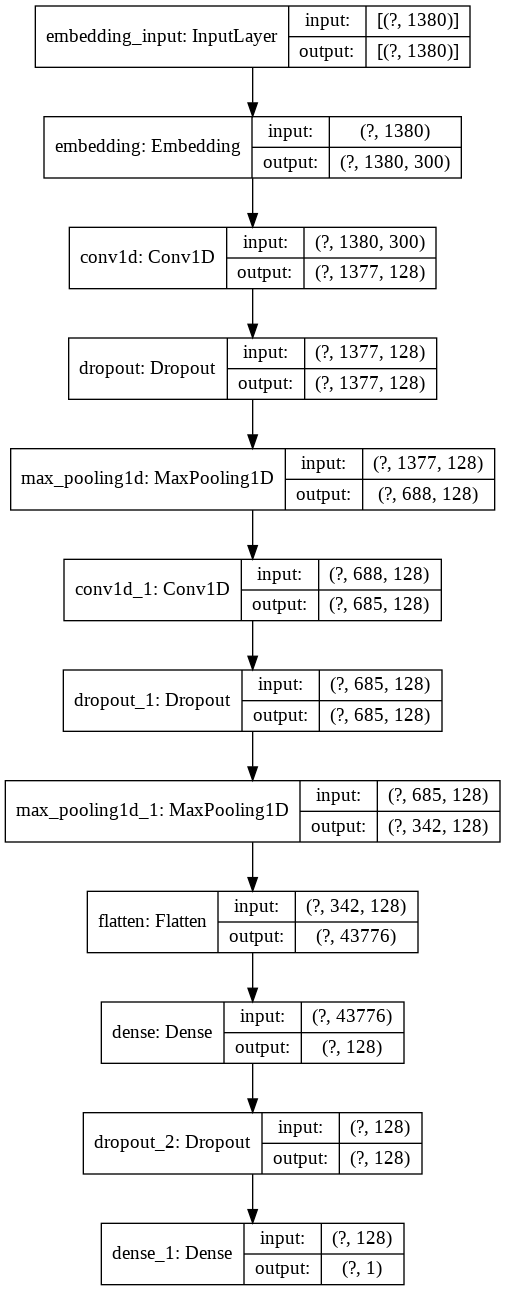

In [22]:
# plot the model
tf.keras.utils.plot_model(model, to_file='txt_embed_cnn.png', show_shapes=True)

- Next, we fit the network on the training data. We use a binary cross entropy loss function because the problem we are learning is a binary classification problem. The efficient Adam implementation of stochastic gradient descent is used and we keep track of accuracy in addition to loss during training. 

- We use early stopping which stops training when a monitored metric in our case validation loss i.e. 'val_loss' has stopped improving. We use a patience of 3 for stopping the training. 

- We also use model checkpoint which monitors validation loss i.e. 'val_loss' and only saves the model if the 'val_loss' for current epoch has been reduced than previous epoch.

- The model is trained for 20 epochs or 20 passes through the training data with a batch size of 16.

- The network configuration and training schedule were found with a little trial and error but are by no means optimal for this problem.

In [0]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# define model checkpoint
mckpt = tf.keras.callbacks.ModelCheckpoint('txt_embed_cnn.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [24]:
# fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16, callbacks=[es, mckpt])

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.5356
Epoch 00001: val_loss improved from inf to 0.69127, saving model to txt_embed_cnn.h5
113/113 [==============================] - 3s 23ms/step - loss: 0.7319 - accuracy: 0.5356 - val_loss: 0.6913 - val_accuracy: 0.5550
Epoch 2/20
110/113 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.6165
Epoch 00002: val_loss improved from 0.69127 to 0.57372, saving model to txt_embed_cnn.h5
113/113 [==============================] - 2s 19ms/step - loss: 0.6552 - accuracy: 0.6200 - val_loss: 0.5737 - val_accuracy: 0.7450
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.7861
Epoch 00003: val_loss improved from 0.57372 to 0.36877, saving model to txt_embed_cnn.h5
113/113 [==============================] - 2s 20ms/step - loss: 0.4504 - accuracy: 0.7861 - val_loss: 0.3688 - val_accuracy: 0.8400
Epoch 4/20
113/113 [==============================] -

- Running the example prints the loss and accuracy on training and validation data at the end of each training epoch. We can see that the model quickly achieves 96% accuracy on the training dataset. At the end of the run, the model achieves an accuracy of 8% on the test dataset which is a good score. This is equal to the [learned Embedding layer](https://github.com/tdikonda/natural_language_processing/blob/master/text_classification/Text_Classification_with_CNN.ipynb) approach.

- After the model is fit, it is evaluated on the test dataset. This dataset contains words that we have not seen before and reviews not seen during training.

In [25]:
# evaluate model on test data
loss, accuracy = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 17ms/step - loss: 0.3486 - accuracy: 0.8600


In [26]:
# Get accuracy on test dataset
print(f'Test Accuracy : {accuracy*100:.2f}')

Test Accuracy : 86.00


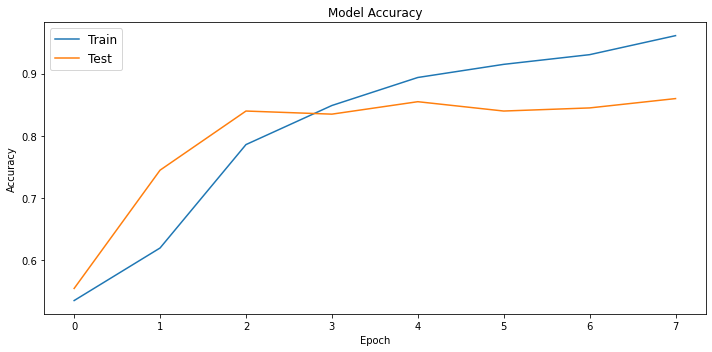

In [27]:
# Plot Model Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(labels=['Train', 'Test'], fontsize='large')
plt.tight_layout()

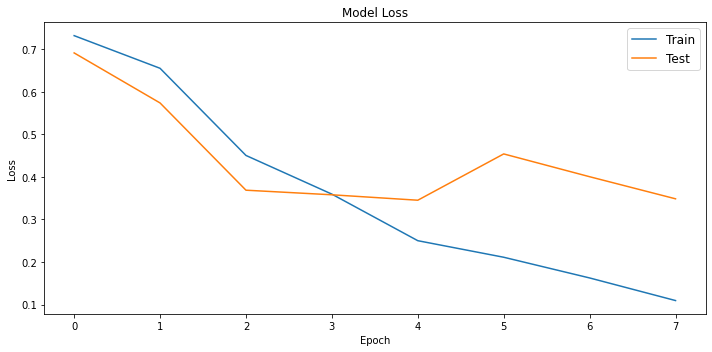

In [28]:
# Plot Model Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(labels=['Train', 'Test'], fontsize='large')
plt.tight_layout()

[How to Develop a Deep Convolutional Neural Network for Sentiment Analysis (Text Classification)](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/)

[Text classification using pre-trained word embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/)

[Best Practices for Text Classification with Deep Learning](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/)